## Analysis and Mitigation of Quantum Noise Effects on the VQE Algorithm

### 1. Overview
This project demonstrates a fundamental challenge in the NISQ era: the impact of **quantum noise** on variational algorithms. I implement a Variational Quantum Eigensolver (VQE) for a 2-qubit Ising system to find its ground state energy under two conditions: an ideal, noiseless simulation and a realistic, noisy one.

### 2. Key objectives 
* Implement VQE: Build and run the VQE algorithm for a simple Hamiltonian using Qiskit. \
  Ising model:  $ H = - Z_0 Z_1 - h (X_0+X_1) $ with $h=0.4$
* Model Realistic Noise: Construct a custom *NoiseModel* based on T1 (amplitude damping) and T2 (phase damping) decoherence times.
* Analyze Noise Impact: Compare the performance and convergence of VQE in both noiseless and noisy environments.
* Visualize the Problem: Plot the 2D energy landscape to show how noise shifts the energy minimum and flattens the optimization surface.
* Mitigate Errors: Apply Zero-Noise Extrapolation (ZNE) to systematically reduce errors and approach the true ground state energy.

### 3. Core Concepts Demonstrated
* Hybrid Quantum-Classical Algorithm: VQE
* Quantum Noise & Decoherence: T1/T2 Relaxation, Quantum Channels
* Quantum Error Mitigation: Zero-Noise Extrapolation (ZNE)
* Parameterized Quantum Circuits: Ansatz Design (*TwoLocal*)
* Hamiltonian Simulation and Expectation Value Measurement

### 4. Workflow 
1. **Setup**: Define the 2-qubit Ising Hamiltonian and a *TwoLocal* circuit.
2. **Baseline Run (Ideal)**: Execute VQE on a noiseless simulator to find the exact ground state energy. This serves as our "true" value.
3. **Noisy Simulation**: Create a *NoiseModel* from T1/T2 parameters and inject it into the simulator. Rerun VQE to obserrve the performance degradation.
4. **Landscape Visualization**: Systematically scan the ansatz parameter space and plot the Hamiltonian's expectation value for both the ideal and noisy simulations. This directly visualizes the noise-induced distortion.
5. **Error Mitigation with ZNE**:
    * Amplify the noise effect by folding unitaries (e.g., at noise scale factors of 1.0, 3.0, 5.0).
    * Run VQE for each noise level to get a series of energy values.
    * Extrapolate these results back to the zero-noise limit using a simple linear or quadratic fit.
    * Compare the mitigated result to the noisy result and the true value.
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit.quantum_info import SparsePauliOp # Efficient representation of Hamiltonian
from qiskit.circuit.library import TwoLocal # Template for making Ansatz
from qiskit_aer.primitives import Estimator # Calculate expectaiton value of quantum circuit
from qiskit_algorithms.optimizers import SPSA # Classic optimizer for VQE parameters. Rigid to noisy environment
from qiskit_algorithms.minimum_eigensolvers import VQEResult 

# Noise modeling imports
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

# Reproducibility
SEED = 42
np.random.seed(SEED)

print('Libraries import success')

Libraries import success


### Step 1. Define the Hamiltonian and Ansatz

#### 1A. Ising Model Hamiltonian
Transverse-field Ising model: \
$H = -Z_0Z_1-h(X_0+X_1) $ where $h=0.4$ \


In Qiskit, **SparespauliOp** class enables to state such operators efficiently. Define each Pauli term as a string and transfer the coefficients as a list.
* **ZZ**: $Z_0Z_1$
* **IX**: $X_0$
* **XI**: $X_1$

**N.B.** Qiskit reads right to left (q1,q0), i.e., **IX**: $I \otimes X = X_0$ 

In [2]:
# Step 1A: Define the Ising Model Hamiltonian

h = 0.4

# Define the Hamiltonian using SparsePauliOp
hamiltonian = SparsePauliOp(["ZZ", "IX", "XI"], coeffs=[-1.0, -h, -h])

# Calculate the exact ground state energy for later comparison
matrix_h = hamiltonian.to_matrix()
exact_eigenvalue = np.min(np.linalg.eigh(matrix_h)[0]).real

print("------------------ Hamiltonian ------------------")
print(hamiltonian)
print("\n---------- Exact Ground State Energy ----------")
print(f"{exact_eigenvalue:.5f}")

------------------ Hamiltonian ------------------
SparsePauliOp(['ZZ', 'IX', 'XI'],
              coeffs=[-1. +0.j, -0.4+0.j, -0.4+0.j])

---------- Exact Ground State Energy ----------
-1.28062


### 1B. Ansatz Circuit Design
Ansatz is a quantum circuit with parameter $\theta$, which VQE adjusts to generate quantum states that minimize Hamiltonian energy. (i.e., circuit to 'mimic' ground state.)


/var/folders/kr/5h7cbtvx7q3fw18_2x3z8t7h0000gn/T/ipykernel_52168/1439543099.py:4: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(num_qubits=2,
/Users/imjinhyeok/anaconda3/envs/jin2023/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:270: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/imjinhyeok/anaconda3/envs/jin2023/lib/python3.11/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(


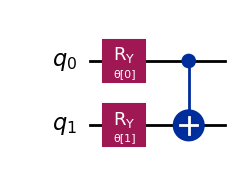


Number of parameters in the ansatz: 2


In [3]:
# Step 1B: Ansatz Circuit Design

# Create a simple two-local ansatz with 2 parameters
ansatz = TwoLocal(num_qubits=2, 
                  rotation_blocks="ry", 
                  entanglement_blocks="cx", 
                  entanglement="linear", 
                  reps=1,
                  skip_final_rotation_layer=True
                 )


display(ansatz.decompose().draw('mpl', style='iqx'))

print(f"\nNumber of parameters in the ansatz: {ansatz.num_parameters}")

### Step 2. Run VQE in Noiseless Environment 

#### VQE consists of 3 parts
1. **Estimator**: Calculator that takes quantum circuits and Hamiltonians as input and computes energy expectation value $\langle \psi(\theta)|H|\psi(\theta)\rangle$.
2. **Optimizer (SPSA)**: Classical algorithm which suggests better parameter ($\theta$) to lower energy; based on energy value computed by **Estimator**.
3. VQE algorithm: Combining these two, repeat the process of executing Ansatz with suggested parameter by **Optimizer** and compute to find the optimal energy.



In [4]:
# Step 2: Run VQE in a Noiseless Environment

# To store the optimization history
noiseless_history = {'iteration': [], 'energy': [], 'params': []}

# 1. Setup the Estimator
# We use Aer Estimator for speed. 'backend_option' with a seed ensures reproducibility.
noiseless_estimator = Estimator(
    backend_options={"method": "statevector", "device": "CPU"},
    run_options={"seed": SEED, "shots": None}, # None means exact statevector simulation
    approximation=True # if added, it means to use exact statevector calculation rather than statistical estimation.
)


# 2. Setup the Optimizer
# SPSA is a good choice for noisy environments, but works well here too.
# maxiter is the maximum number of optimization steps.
optimizer = SPSA(maxiter=100)


# 3. Define the VQE object in a functional way
def run_vqe_noiseless(estimator, ansatz, hamiltonian, optimizer):
    """A helper function to run the VQE loop."""
    # Reset noiseless_history
    noiseless_history['iteration'].clear()
    noiseless_history['energy'].clear()
    noiseless_history['params'].clear()

    iteration_counter = 0

    # Define the objective function for the optimizer
    def objective_function(params):
        nonlocal iteration_counter # Use the couneter from the outer scope

        # Execute the quantum circuit to get the energy
        job = estimator.run(ansatz, hamiltonian, parameter_values=params)
        result = job.result()
        energy = result.values[0]

        # Log the current results
        noiseless_history['iteration'].append(iteration_counter)
        noiseless_history['energy'].append(energy)
        noiseless_history['params'].append(params)

        if iteration_counter % 10 == 0:
            print(f"Iteration {iteration_counter:4d}: Energy = {energy:.5f}")

        iteration_counter += 1
        return energy
        
    # Chosse a random initial point for the parameters
    initial_point = np.random.random(ansatz.num_parameters)

    # Run the optimization
    result = optimizer.minimize(
        fun=objective_function,
        x0=initial_point
    )

    # Create a VQEResult object to store the final output
    vqe_result = VQEResult()
    vqe_result.eigenvalue = result.fun
    vqe_result.optimal_parameters = result.x
    return vqe_result


# ------ Execute the noieless VQE run ------
print("--- Starting Noiseless VQE Run ---")
noiseless_vqe_result = run_vqe_noiseless(noiseless_estimator, ansatz, hamiltonian, optimizer)

print("\n--- Noiseless VQE Result ---")
print(f"Optimal energy: {noiseless_vqe_result.eigenvalue:.5f}")
print(f"Exact energy:   {exact_eigenvalue:.5f}")
print(f"Energy error:   {abs(noiseless_vqe_result.eigenvalue - exact_eigenvalue):.5f}")

--- Starting Noiseless VQE Run ---
Iteration    0: Energy = -0.83648
Iteration   10: Energy = -1.05145
Iteration   20: Energy = -0.83648
Iteration   30: Energy = -0.83648
Iteration   40: Energy = -1.15235
Iteration   50: Energy = -0.83648
Iteration   60: Energy = -1.19963
Iteration   70: Energy = -1.22728
Iteration   80: Energy = -1.24129
Iteration   90: Energy = -1.26722
Iteration  100: Energy = -1.25573
Iteration  110: Energy = -1.26086
Iteration  120: Energy = -1.25666
Iteration  130: Energy = -1.26661
Iteration  140: Energy = -1.26286
Iteration  150: Energy = -1.26492
Iteration  160: Energy = -1.26900
Iteration  170: Energy = -1.26611
Iteration  180: Energy = -1.26910
Iteration  190: Energy = -1.26870
Iteration  200: Energy = -1.26861
Iteration  210: Energy = -1.26949
Iteration  220: Energy = -1.26888
Iteration  230: Energy = -1.26915
Iteration  240: Energy = -1.26751
Iteration  250: Energy = -1.28057

--- Noiseless VQE Result ---
Optimal energy: -1.28057
Exact energy:   -1.28062
E

In [5]:
# Check noiseless_history 
print("--- Contents of noiseless_history ---")
print(f"Number of iterations logged: {len(noiseless_history['iteration'])}")
print("\nFirst 5 energy values:")
print(noiseless_history['energy'][:5])
print("\nLast 5 energy values:")
print(noiseless_history['energy'][-5:])

--- Contents of noiseless_history ---
Number of iterations logged: 251

First 5 energy values:
[-0.8364802969445059, -1.1523541610569998, -1.1523541610569998, -0.8364802969445059, -1.0514506330465392]

Last 5 energy values:
[-1.2679268383206326, -1.2692908113200132, -1.2692347943796527, -1.2680312982235866, -1.2805694809002914]


### Step 3. VQE with Noise

#### 2 types of realistic Noise 
1. Depolarizing Error: The most basic error model, where qubit state changes to a completely random state (a fully mixed state) with a certain probability when the gate operates.
2. Thermal Relaxation Error: Modeling a physical phenomena where qubits lose energy(T1) or information(T2) through interaction with the environment. It depends on the 'time' of gate operation.

#### This step consists of 
* 3A: Build a Noise model
* 3B. Run VQE in Noisy environment

#### Step 3A: Build a Noise model

First, create **NoiseModel** object which includes 2 errors above using tools in *qiskit_aer.noise*
* Set the time unit of T1 and T2 to 'ns'. (Similar to the specifications of acutal equipments)
* Define the operating time for each gate.
* Transfer these information to **thermal_relaxation_error** and create the error over time.
* Add **depolarizing_error** to model the gate's inherent imperfection.


In [6]:
# --- Step 3A: Build the Noise Model ---

# T1 and T2 values for a typical superconducting qubit (in nanoseconds)
T1 = 50000 # 50 μs
T2 = 70000 # 70 μs

# Define gate times for thermal relaxation (in nanoseconds)
# A single-qubit gate is much faster than a CNOT.
time_sx = 20 #ns, sqrt(X) gate
time_cx = 300 #ns Controlled-Not gate

# Define depolarizing erorr prpobabilities
p_depol_1q = 0.005 # 0.5% error on single-qubit gates
p_depol_2q = 0.05 # 5% error on two-qubit gates

# 1. Create the error objects
# Thermal relaxation error
thermal_error_1q = thermal_relaxation_error(T1, T2, time_sx)
thermal_error_2q = thermal_relaxation_error(T1, T2, time_cx).expand(
                   thermal_relaxation_error(T1, T2, time_cx)) # Apply to both qubits in a 2Q gate

# Deplarizing error
depol_error_1q = depolarizing_error(p_depol_1q, 1)
depol_error_2q = depolarizing_error(p_depol_2q, 2)


# 2. Combine errors
# We chain them together: first depolarizing, then thermal relaxation 
full_error_1q = depol_error_1q.compose(thermal_error_1q)
full_error_2q = depol_error_2q.compose(thermal_error_2q)


# 3. Builed the noise model
noise_model = NoiseModel()
# Add errors to the basis gates of the simulation
noise_model.add_all_qubit_quantum_error(full_error_1q, ["sx", "ry"]) # Our ansatz uses 'ry'
noise_model.add_all_qubit_quantum_error(full_error_2q, ["cx"])

print("--- Noise Model Created ---")
print(noise_model)                                         
                                        

--- Noise Model Created ---
NoiseModel:
  Basis gates: ['cx', 'id', 'ry', 'rz', 'sx']
  Instructions with noise: ['sx', 'ry', 'cx']
  All-qubits errors: ['sx', 'ry', 'cx']


#### Step 3B: Run VQE in Noisy environment 

One should create **Estimator** for *NoiseModel*

* Since Noise Simulation is a probabilistic process, this should be executed based on 'shots'. It is not a perfect mathematical calculation (as 'approximation=True' for Noiseless Model)
* Pass the *NoiseModel* into **Estimator** backend_options that simulator instruct to aply this noise.

In [7]:
# --- Step 3B: Run VQE in Noisy environment ---

# To store the history of the noisy run
noisy_history = {'iteration': [], 'energy': [], 'params': []}

# 1. Setup the Noisy Estimator
# 'noise_model' is passed into the 'backend_options'
noisy_estimator = Estimator(
    backend_options={
        "method": "statevector",
        "device": "CPU",
        "noise_model": noise_model # Here we inject noise
    },
    run_options={"seed": SEED, "shots": 8192}, # Higher shot count for better statistics
    approximation=False # A shot-based simulation, not an exact calculation
)

# Reuse the optimizer
# optimizer = SPSA(maxiter=100)

# 2. Define the VQE execution logic for the noisy run
def run_vqe_noisy(estimator, ansatz, hamiltonian, optimizer):
    noisy_history['iteration'].clear()
    noisy_history['energy'].clear()
    noisy_history['params'].clear()
    iteration_counter = 0

    def objective_function(params):
        nonlocal iteration_counter
        job = estimator.run(ansatz, hamiltonian, parameter_values=params)
        energy = job.result().values[0]
        noisy_history['iteration'].append(iteration_counter)
        noisy_history['energy'].append(energy)
        noisy_history['params'].append(params)
        if iteration_counter % 10 == 0:
            print(f"Iteration {iteration_counter:4d}: Energy = {energy:.5f}")
        iteration_counter += 1
        return energy

    initial_point = np.random.random(ansatz.num_parameters)
    result = optimizer.minimize(fun=objective_function, x0=initial_point)

    vqe_result = VQEResult()
    vqe_result.eigenvalue = result.fun
    vqe_result.optimal_parameters = result.x
    return vqe_result


# --- Execute the noisy VQE ---
print("\n--- Starting Noisy VQE Run ---")
noisy_vqe_result = run_vqe_noisy(noisy_estimator, ansatz, hamiltonian, optimizer)

print(f"Optimal energy (noisy):  {noisy_vqe_result.eigenvalue:.5f}")
print(f"Optimal energy (ideal):  {noiseless_vqe_result.eigenvalue:.5f}")
print(f"Exact energy:)           {exact_eigenvalue:.5f}")
print(f"\nError introduced by noise: {abs(noisy_vqe_result.eigenvalue - exact_eigenvalue):.5f}")




--- Starting Noisy VQE Run ---
Iteration    0: Energy = -1.13774
Iteration   10: Energy = -1.13774
Iteration   20: Energy = -1.09268
Iteration   30: Energy = -1.09268
Iteration   40: Energy = -1.15488
Iteration   50: Energy = -1.13774
Iteration   60: Energy = -0.69556
Iteration   70: Energy = -0.96113
Iteration   80: Energy = -1.09648
Iteration   90: Energy = -1.19780
Iteration  100: Energy = -1.18364
Iteration  110: Energy = -1.18789
Iteration  120: Energy = -1.19136
Iteration  130: Energy = -1.19380
Iteration  140: Energy = -1.19053
Iteration  150: Energy = -1.19380
Iteration  160: Energy = -1.19189
Iteration  170: Energy = -1.19141
Iteration  180: Energy = -1.19316
Iteration  190: Energy = -1.19380
Iteration  200: Energy = -1.19526
Iteration  210: Energy = -1.19419
Iteration  220: Energy = -1.19341
Iteration  230: Energy = -1.19302
Iteration  240: Energy = -1.19336
Iteration  250: Energy = -1.21030
Optimal energy (noisy):  -1.21030
Optimal energy (ideal):  -1.28057
Exact energy:)  

### Step 4: Result Visualization (1) - VQE convergence comparison

#### Visualize **Optimization path**
* x-axis: Iteration
* y-axis: Energy

Noiseless VQE would converge towards 'Ideal energy' smoothly. However, Noisy VQE's energy would fluctuate and being stochastic, end up to converge at a higher point than the 'Ideal energy'.

Exact ground state energy: -1.28062


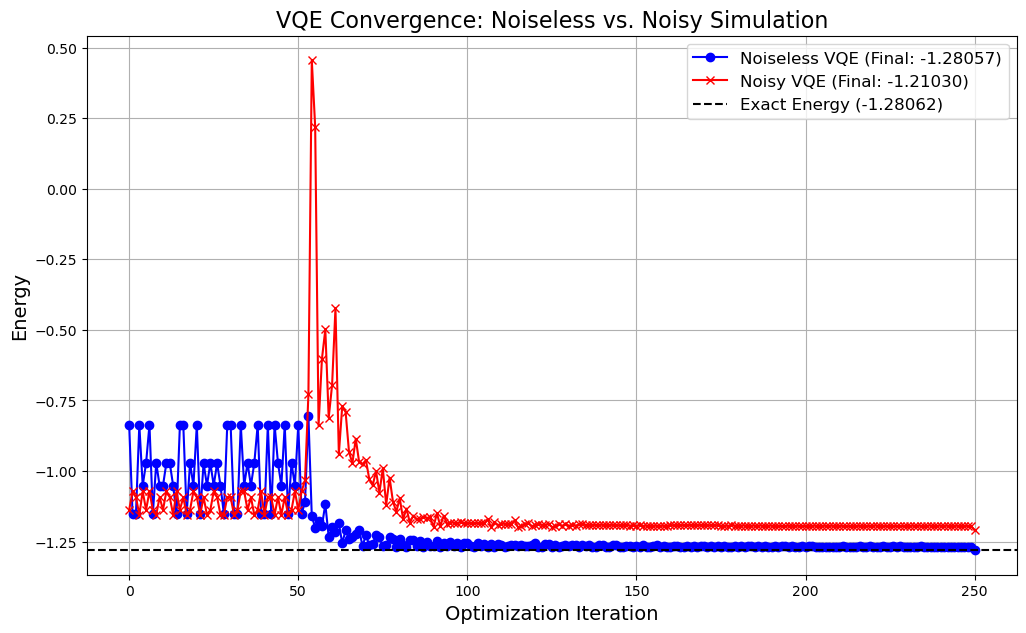

In [8]:
# --- Step 4: Visualize VQE Convergence ---

# Exact energy calculated as reference in Step 1
print(f"Exact ground state energy: {exact_eigenvalue:.5f}")

plt.figure(figsize=(12, 7))

# Plot the Noiseless VQE history 
plt.plot(
    noiseless_history['iteration'],
    noiseless_history['energy'],
    'bo-',
    label=f"Noiseless VQE (Final: {noiseless_vqe_result.eigenvalue:.5f})"
)

# Plot the Noisy VQE history
plt.plot(
    noisy_history['iteration'],
    noisy_history['energy'],
    'rx-',
    label=f"Noisy VQE (Final: {noisy_vqe_result.eigenvalue:.5f})"
)

# Plot the exact energy as a horizontal line
plt.axhline(
    y=exact_eigenvalue,
    color='k',
    linestyle='--',
    label=f"Exact Energy ({exact_eigenvalue:.5f})"
)

# Add plot labels
plt.title('VQE Convergence: Noiseless vs. Noisy Simulation', fontsize=16)
plt.xlabel('Optimization Iteration', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('/Users/imjinhyeok/Documents/GitHub/Quantum-NoIse-and-Algorithms/01_vqe_ising_noise/zne_results/vqe_convergence.png')
plt.show()


### Step 5: Result Visualization (2) - Energy Landscape comparison

#### VQE is similar to a process to explore the lowest valley (minimum energy) in a "Energy Landscape". Optimizer descend following the gradient of this landscape.

* If Noise has a potential to distort this landscape itself, **Optimizer** could get lost or arrive at a wrong point.
* The 'ansatz' in this case has 2 parameters ($\theta_0, \theta_1$), so this terrain can be perfectly mapped as a 3D surface or a 2D contour map.



--- Starting Energy Landscape Scan ---
--- Scan complete. Plotting landscapes... ---


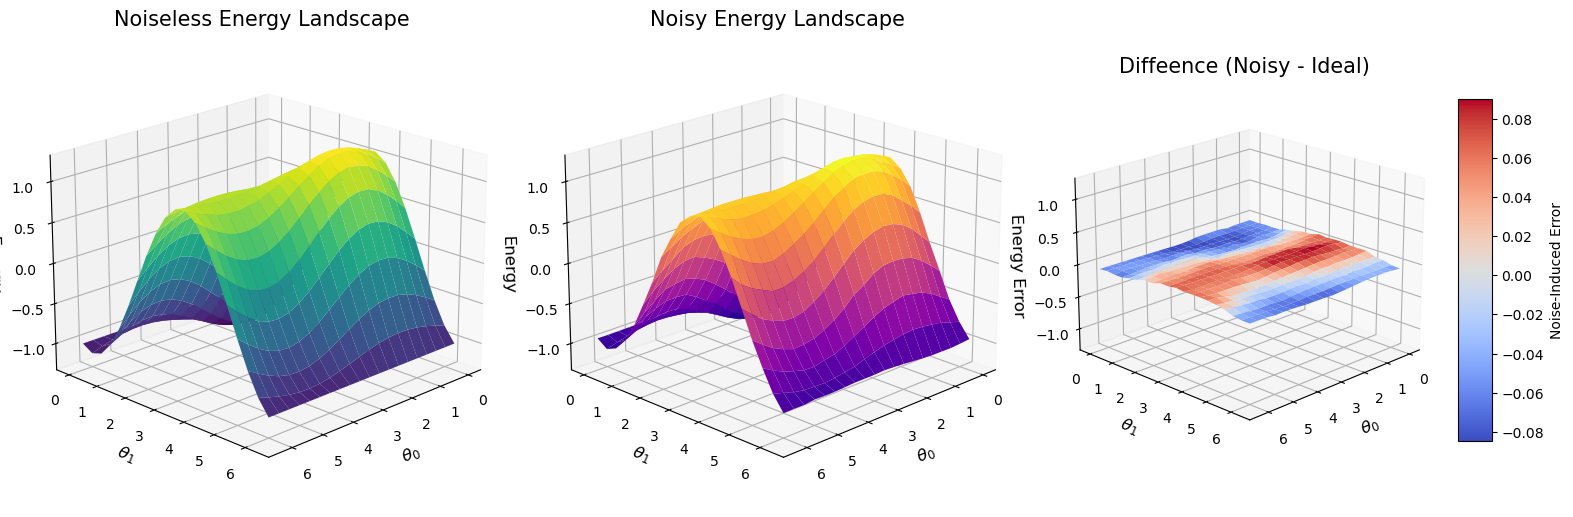

--- Landscape Difference Analysis ---
Mean difference (Noisy - Ideal): 0.00217
Max difference:                  0.09015
Min difference:                  -0.09744


In [9]:
#  --- Step 5: Visualize the Energy Landscape ---

print("--- Starting Energy Landscape Scan ---")

# 1. Create a grid of parameters 
theta_0 = np.linspace(0, 2 * np.pi, 20)
theta_1 = np.linspace(0, 2 * np.pi, 20)
param_grid_0, param_grid_1 = np.meshgrid(theta_0, theta_1)

# Flatten the grid into a list of parameter pairs
# 20 x 20 = 400 parameter sets
param_sets = np.array([param_grid_0.ravel(), param_grid_1.ravel()]).T

# 2. Run the scan for the Noiseless Estimator
# Run 400 points as a single "batch" job
job_ideal = noiseless_estimator.run(
    circuits=[ansatz] * len(param_sets),
    observables=[hamiltonian] * len(param_sets),
    parameter_values=param_sets
)
energies_ideal = job_ideal.result().values
energies_ideal_grid = energies_ideal.reshape(param_grid_0.shape)

# 3. Run the scan for the Noisy Estimator
job_noisy = noisy_estimator.run(
    circuits=[ansatz] * len(param_sets),
    observables=[hamiltonian] * len(param_sets),
    parameter_values=param_sets
)
energies_noisy = job_noisy.result().values
energies_noisy_grid = energies_noisy.reshape(param_grid_0.shape)

print("--- Scan complete. Plotting landscapes... ---")

# 4. Plot the results
fig, axes = plt.subplots(1, 3, figsize=(16, 6), subplot_kw={"projection": "3d"})

# Plot Noiseles Landscape
ax0 = axes[0]
ax0.plot_surface(param_grid_0, param_grid_1, energies_ideal_grid, cmap='viridis', rstride=1, cstride=1)
ax0.set_title('Noiseless Energy Landscape', fontsize=15)
ax0.set_xlabel(r'$\theta_0$', fontsize=12)
ax0.set_ylabel(r'$\theta_1$', fontsize=12)
ax0.set_zlabel('Energy', fontsize=12)
ax0.view_init(elev=20, azim=45)

# Plot Noisy Landscape
ax1 = axes[1]
ax1.plot_surface(param_grid_0, param_grid_1, energies_noisy_grid, cmap='plasma', rstride=1, cstride=1)
ax1.set_title('Noisy Energy Landscape', fontsize=15)
ax1.set_xlabel(r'$\theta_0$', fontsize=12)
ax1.set_ylabel(r'$\theta_1$', fontsize=12)
ax1.set_zlabel('Energy', fontsize=12)
ax1.view_init(elev=20, azim=45)

ax2 = axes[2]
difference_grid = energies_noisy_grid - energies_ideal_grid
surf = ax2.plot_surface(param_grid_0, param_grid_1, energies_ideal_grid - energies_noisy_grid, cmap='coolwarm', rstride=1, cstride=1)
ax2.set_title('Diffeence (Noisy - Ideal)', fontsize=15)
ax2.set_xlabel(r'$\theta_0$', fontsize=12)
ax2.set_ylabel(r'$\theta_1$', fontsize=12)
ax2.set_zlabel('Energy Error', fontsize=12)
ax2.view_init(elev=20, azim=45)
fig.colorbar(surf, ax=ax2, shrink=0.6, aspect=10, label='Noise-Induced Error')


# Set the Z-axis limits to be the same for plots
min_energy = min(np.min(energies_ideal_grid), np.min(energies_noisy_grid))
max_energy = max(np.max(energies_ideal_grid), np.max(energies_noisy_grid))
ax0.set_zlim(min_energy, max_energy)
ax1.set_zlim(min_energy, max_energy)
ax2.set_zlim(min_energy, max_energy)

plt.savefig('/Users/imjinhyeok/Documents/GitHub/Quantum-NoIse-and-Algorithms/01_vqe_ising_noise/zne_results/energy_landscape.png')

plt.tight_layout()
plt.show()

difference_grid = energies_noisy_grid - energies_ideal_grid

print("--- Landscape Difference Analysis ---")
print(f"Mean difference (Noisy - Ideal): {np.mean(difference_grid):.5f}")
print(f"Max difference:                  {np.max(difference_grid):.5f}")
print(f"Min difference:                  {np.min(difference_grid):.5f}")

### Step 6: Mitigate Errors with ZNE (Zero-Noise Extrapolation)

#### How to predict Zero-Noise by Extrapolation?
Running a circuit with *zero* noise. An alternative way to estimate such situation is to run a circuit with **1x** noise, **3x** noie, and **5x** noise. Corresponding energy points ($E_1, E_3, E_5$) can predict the noiseless energy by extrapolating.

#### How to get 3x, 5x noie?
Gate Folding. Since **CX** gate is its own inverse, the circuit **Ry-CX-CX-CX-Ry** is logically identical to **Ry-CX-Ry** but also accumulated 3 times of CNOT noise.


#### Step 6A: Run VQE at scaled Noise Levels 
* Loop through noise scales (1, 3, 5). Manually build the folded circuit and run a full VQE optimization to find its ground state energy. 

In [10]:
# --- Step 6A: Run VQE at scaled Noise Levels ---

from scipy.optimize import curve_fit
from qiskit.circuit import QuantumCircuit

noise_scale_factors = [1, 3, 5]
vqe_energies_at_scales = []

# Get the parameters from our original ansatz
params_list = ansatz.parameters

print("--- Starting ZNE VQE Runs ---")

for scale in noise_scale_factors:
    print(f"\n--- Runnning VQE for noise scale = {scale} ---")

    # 1. Create the "folded" ansatz manually
    # We build a new circuit with 'scale' number of CNOTs
    qc_scaled = QuantumCircuit(2)
    qc_scaled.ry(params_list[0], 0)
    qc_scaled.ry(params_list[1], 1)

    # Add the CX gates. (For scale = 1, 3, 5 => 1 CX, 3 CXs, 5 CXs)
    for _ in range(scale):
        qc_scaled.cx(0, 1)

    # 2. Run VQE with noisier circuit
    # We use the same noisy_estimator, the circuit itself amplifies the noise.
    
    # We need a history dictionary for each run
    zne_history = {'iteration': [], 'energy': [], 'params': []}

    def run_vqe_zne(estimator, ansatz_to_run, optimizer):
        zne_history['iteration'].clear()
        zne_history['energy'].clear()
        zne_history['params'].clear()
        iteration_counter = 0

        # Define the objective function for this specific circuit
        def objective_function(params):
            nonlocal iteration_counter
            # Bind the parameters and run
            job = estimator.run(ansatz_to_run, hamiltonian, parameter_values=params)
            energy = job.result().values[0]

            # Log history
            zne_history['iteration'].append(iteration_counter)
            zne_history['energy'].append(energy)

            if iteration_counter % 50 == 0:
                print(f" Iter {iteration_counter:3d}: Energy = {energy:.5f}")
            iteration_counter += 1
            return energy

        # Start from a new random point
        initial_point = np.random.random(ansatz_to_run.num_parameters)

        # Run the optimizer
        result = optimizer.minimize(fun=objective_function, x0=initial_point)
        return result.fun 

    # --- Execute the VQE run for this scale factor ---
    final_energy = run_vqe_zne(noisy_estimator, qc_scaled, optimizer)
    vqe_energies_at_scales.append(final_energy)

    print(f"--- Final energy at scale {scale}: {final_energy:.5f} ---")

print("\n--- ZNE Analysis Data ---")
print(f"Noise scales (x): {noise_scale_factors}")
print(f"Energies measured (y): {[round(e, 5) for e in vqe_energies_at_scales]}")


--- Starting ZNE VQE Runs ---

--- Runnning VQE for noise scale = 1 ---
 Iter   0: Energy = -1.01328
 Iter  50: Energy = -0.93291
 Iter 100: Energy = -1.19009
 Iter 150: Energy = -1.19312
 Iter 200: Energy = -1.19326
 Iter 250: Energy = -1.21001
--- Final energy at scale 1: -1.21001 ---

--- Runnning VQE for noise scale = 3 ---
 Iter   0: Energy = -1.03901
 Iter  50: Energy = -0.94722
 Iter 100: Energy = -1.19302
 Iter 150: Energy = -1.19150
 Iter 200: Energy = -1.19385
 Iter 250: Energy = -1.20693
--- Final energy at scale 3: -1.20693 ---

--- Runnning VQE for noise scale = 5 ---
 Iter   0: Energy = -1.00190
 Iter  50: Energy = -1.00190
 Iter 100: Energy = -1.05903
 Iter 150: Energy = -1.19229
 Iter 200: Energy = -1.19321
 Iter 250: Energy = -1.20635
--- Final energy at scale 5: -1.20635 ---

--- ZNE Analysis Data ---
Noise scales (x): [1, 3, 5]
Energies measured (y): [-1.21001, -1.20693, -1.20635]


#### Step 6B: Fit Data and Plot Extrapolation
* Use **scipy.optimize.curve_fit** to find the fit 3 data points for predicting final result


--- ZNE Fit Results ---
Fitted slope (a): 0.00092
Fitted intercept (E_0): -1.21051 <-- This is our Mitigated Result


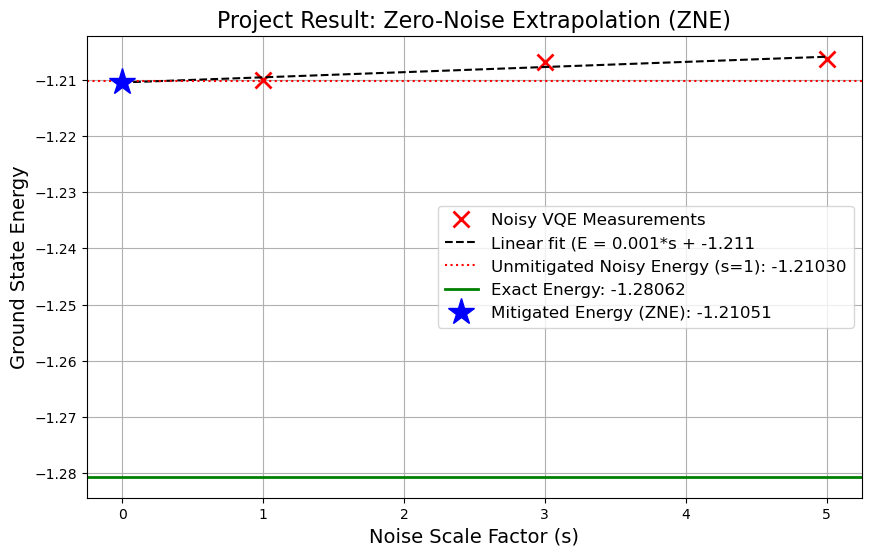

In [11]:
# --- Step 6B: Fit Data and Plot Extrapolation ---

# 1. Define the linear function we are fitting to: E(s) = a*s + E_0
# 's' is the noise scale, 'a' is the slope, 'E_0' is the y-intercept
def linear_fit(s, a, e0):
    return a * s + e0 # Linear Model Assumption

# 2. Use curve_fit to find the best 'a' and 'e0'
# popt = "optimal parameters" ('a' and 'e0')
# pcov = "covariance" (don't need)
popt, pcov = curve_fit(linear_fit, noise_scale_factors, vqe_energies_at_scales)

a, e0_extrapolated = popt

print("\n--- ZNE Fit Results ---")
print(f"Fitted slope (a): {a:.5f}")
print(f"Fitted intercept (E_0): {e0_extrapolated:.5f} <-- This is our Mitigated Result")


# 3. Plot the final ZNE graph
plt.figure(figsize=(10, 6))

# Plot the noisy measurements
plt.plot(noise_scale_factors, vqe_energies_at_scales, 'rx', markersize=12, mew=2, label='Noisy VQE Measurements')

# Plot the fitted line
s_fit = np.linspace(0, max(noise_scale_factors), 100)
e_fit = linear_fit(s_fit, a, e0_extrapolated)
plt.plot(s_fit, e_fit, 'k--', label=f'Linear fit (E = {a:.3f}*s + {e0_extrapolated:.3f}')

# --- Plot the comparison lines ---

# Plot the Unmitigated Noisy result 
plt.axhline(
    noisy_vqe_result.eigenvalue,
    color='r',
    linestyle=':',
    label=f'Unmitigated Noisy Energy (s=1): {noisy_vqe_result.eigenvalue:.5f}'
)

# Plot the True Exact Energy
plt.axhline(
    exact_eigenvalue,
    color='g',
    linestyle='-',
    linewidth=2,
    label=f'Exact Energy: {exact_eigenvalue:.5f}'
)

# Plot our final, Mitigated Result at s=0
plt.plot(
    0, e0_extrapolated,
    'b*',
    markersize=20,
    label=f'Mitigated Energy (ZNE): {e0_extrapolated:.5f}'
)
    

plt.title('Project Result: Zero-Noise Extrapolation (ZNE)', fontsize=16)
plt.xlabel('Noise Scale Factor (s)', fontsize=14)
plt.ylabel('Ground State Energy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('/Users/imjinhyeok/Documents/GitHub/Quantum-NoIse-and-Algorithms/01_vqe_ising_noise/zne_results/zne_scale135.png')
plt.show()


--- Starting Robust ZNE (Averaging 10 runs per scale) ---

--- Processing Noise Scale = 1 ---
  Starting VQE Run 1/10, Scale 1...
     (Run 1/10, Scale 1) Iter   0: E = -0.88682
     (Run 1/10, Scale 1) Iter  50: E = -1.03750
     (Run 1/10, Scale 1) Iter 100: E = -1.19468
     (Run 1/10, Scale 1) Iter 150: E = -1.19663
     (Run 1/10, Scale 1) Iter 200: E = -1.19658
     (Run 1/10, Scale 1) Iter 250: E = -1.20835
  Run 1/10, Scale 1 Complete. Final Energy: -1.20835
  Starting VQE Run 2/10, Scale 1...
     (Run 2/10, Scale 1) Iter   0: E = -1.11304
     (Run 2/10, Scale 1) Iter  50: E = -1.01992
     (Run 2/10, Scale 1) Iter 100: E = -1.00723
     (Run 2/10, Scale 1) Iter 150: E = -1.18115
     (Run 2/10, Scale 1) Iter 200: E = -1.19326
     (Run 2/10, Scale 1) Iter 250: E = -1.20654
  Run 2/10, Scale 1 Complete. Final Energy: -1.20654
  Starting VQE Run 3/10, Scale 1...
     (Run 3/10, Scale 1) Iter   0: E = -1.09253
     (Run 3/10, Scale 1) Iter  50: E = -1.07358
     (Run 3/10, Scal

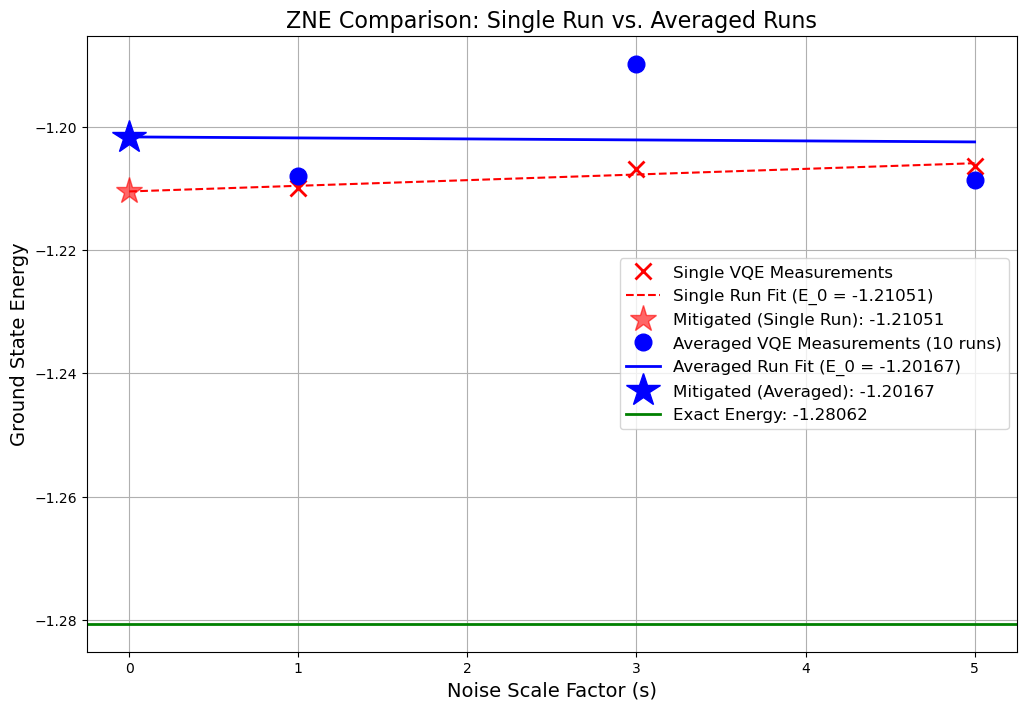

In [15]:
# --- Step 6C: Robust ZNE with Averaging ---
import time
import numpy as np
from scipy.optimize import curve_fit
from qiskit.circuit import QuantumCircuit
import matplotlib.pyplot as plt

# --- Momory needs Previous results from "Step 6B" ---
# vqe_energies_at_scales (Single-run Energies List)
# a, e0_extrapolated (Single-run Fitting Result)
# ----------------------------------------------------

num_runs = 10 # Number of execution for each scale
noise_scale_factors = [1, 3, 5]
vqe_energies_avg = [] # Average energies list for each scale
all_run_data = {} # Save all run data

print(f"--- Starting Robust ZNE (Averaging {num_runs} runs per scale) ---")
# print(f"This will take a significant amount of time...")

# --- Function for VQE run ---
def run_single_vqe(estimator, ansatz_to_run, optimizer, run_info=""):
    iteration_counter = 0
    def objective_function(params):
        nonlocal iteration_counter
        job = estimator.run(ansatz_to_run, hamiltonian, parameter_values=params)
        energy = job.result().values[0]
        if iteration_counter % 50 == 0:
            print(f"     ({run_info}) Iter {iteration_counter:3d}: E = {energy:.5f}")
        iteration_counter += 1
        return energy

    initial_point = np.random.random(ansatz_to_run.num_parameters)
    result = optimizer.minimize(fun=objective_function, x0=initial_point)
    return result.fun

# --- Main averaging Loop ---
start_time = time.time()
param_list = ansatz.parameters

for scale in noise_scale_factors:
    print(f"\n--- Processing Noise Scale = {scale} ---")
    energies_for_this_scale = []
    all_run_data[scale] = []

    # 1. 스케일링된 회로 재생성
    qc_scaled = QuantumCircuit(2)
    qc_scaled.ry(params_list[0], 0)
    qc_scaled.ry(params_list[1], 1)
    for _ in range(scale):
        qc_scaled.cx(0, 1)

    # 2. VQE를 num_runs 만큼 반복 실행
    for run in range(num_runs):
        run_label = f"Run {run+1}/{num_runs}, Scale {scale}"
        print(f"  Starting VQE {run_label}...")
        final_energy = run_single_vqe(noisy_estimator, qc_scaled, optimizer, run_label)
        print(f"  {run_label} Complete. Final Energy: {final_energy:.5f}")
        energies_for_this_scale.append(final_energy)
        all_run_data[scale].append(final_energy)

    # 3. 평균 계산 및 저장
    avg_energy = np.mean(energies_for_this_scale)
    vqe_energies_avg.append(avg_energy)
    print(f"--- Average energy at scale {scale}: {avg_energy:.5f} (StdDev: {np.std(energies_for_this_scale):.5f}) ---")

end_time = time.time()
print(f"\nRobust ZNE runs complete. Total time: {end_time - start_time:.2f} seconds")

# --- 4. *평균* 데이터로 ZNE 피팅 ---
print("\n--- ZNE Fit Results (Averaged) ---")

popt_avg, pcov_avg = curve_fit(linear_fit, noise_scale_factors, vqe_energies_avg)
a_avg, e0_extrapolated_avg = popt_avg

print(f"Fitted slope (a_avg):     {a_avg:.5f}")
print(f"Fitted intercept (E_0_avg): {e0_extrapolated_avg:.5f}  <-- This is our new Robust Mitigated Result!")

# --- 5. 비교 플롯 그리기 (단일 실행 vs 평균 실행) ---
plt.figure(figsize=(12, 8))
plt.title('ZNE Comparison: Single Run vs. Averaged Runs', fontsize=16)

# (1) 단일 실행 ZNE (Step 6B의 결과) - 빨간색
plt.plot(noise_scale_factors, vqe_energies_at_scales, 'rx', markersize=12, mew=2, label='Single VQE Measurements')
s_fit_single = np.linspace(0, max(noise_scale_factors), 100)
e_fit_single = linear_fit(s_fit_single, a, e0_extrapolated) # 'a', 'e0_extrapolated'는 6B의 변수
plt.plot(s_fit_single, e_fit_single, 'r--', label=f'Single Run Fit (E_0 = {e0_extrapolated:.5f})')
plt.plot(0, e0_extrapolated, 'r*', markersize=20, alpha=0.6, label=f'Mitigated (Single Run): {e0_extrapolated:.5f}')

# (2) 평균 실행 ZNE (방금 계산한 결과) - 파란색
plt.plot(noise_scale_factors, vqe_energies_avg, 'bo', markersize=12, label=f'Averaged VQE Measurements ({num_runs} runs)')
s_fit_avg = np.linspace(0, max(noise_scale_factors), 100)
e_fit_avg = linear_fit(s_fit_avg, a_avg, e0_extrapolated_avg)
plt.plot(s_fit_avg, e_fit_avg, 'b-', linewidth=2, label=f'Averaged Run Fit (E_0 = {e0_extrapolated_avg:.5f})')
plt.plot(0, e0_extrapolated_avg, 'b*', markersize=25, label=f'Mitigated (Averaged): {e0_extrapolated_avg:.5f}')

# (3) 참조선 (정답)
plt.axhline(exact_eigenvalue, color='g', linestyle='-', linewidth=2, label=f'Exact Energy: {exact_eigenvalue:.5f}')

plt.xlabel('Noise Scale Factor (s)', fontsize=14)
plt.ylabel('Ground State Energy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('/Users/imjinhyeok/Documents/GitHub/Quantum-NoIse-and-Algorithms/01_vqe_ising_noise/zne_results/vqe_avg10.png')
plt.show()



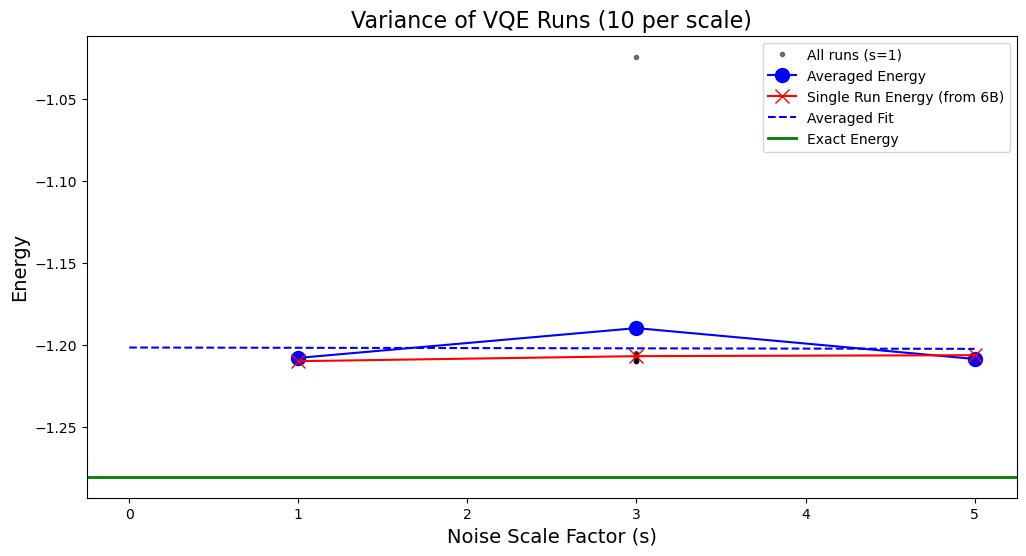

In [17]:
# --- (보너스 플롯) VQE 실행의 분산(Variance) 시각화 ---
plt.figure(figsize=(12, 6))
for scale in noise_scale_factors:
    # 각 스케일의 모든 10개 실행 결과를 검은 점으로 찍기
    plt.plot([scale]*num_runs, all_run_data[scale], 'k.', alpha=0.5, label=f'All runs (s={scale})' if scale==1 else None)
    
# 평균값(파란색)과 단일값(빨간색)을 그 위에 그리기
plt.plot(noise_scale_factors, vqe_energies_avg, 'bo-', markersize=10, label='Averaged Energy')
plt.plot(noise_scale_factors, vqe_energies_at_scales, 'rx-', markersize=10, label='Single Run Energy (from 6B)')
plt.plot(s_fit_avg, e_fit_avg, 'b--', label='Averaged Fit')
plt.axhline(exact_eigenvalue, color='g', linestyle='-', linewidth=2, label='Exact Energy')

plt.title(f'Variance of VQE Runs ({num_runs} per scale)', fontsize=16)
plt.xlabel('Noise Scale Factor (s)', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.legend()
plt.savefig('/Users/imjinhyeok/Documents/GitHub/Quantum-NoIse-and-Algorithms/01_vqe_ising_noise/zne_results/vqe_variance10.png')
plt.show()


--- ZNE Analysis (Quadratic Fit) ---
Noise scales: [1, 3, 5]
Energies measured: [-1.21001, -1.20693, -1.20635]

--- ZNE Fit Results (Quadratic) ---
Fitted a (s^2 term): -0.00031
Fitted b (s term):   0.00278
Fitted intercept (E_0): -1.21248  <-- This is our Mitigated Result!


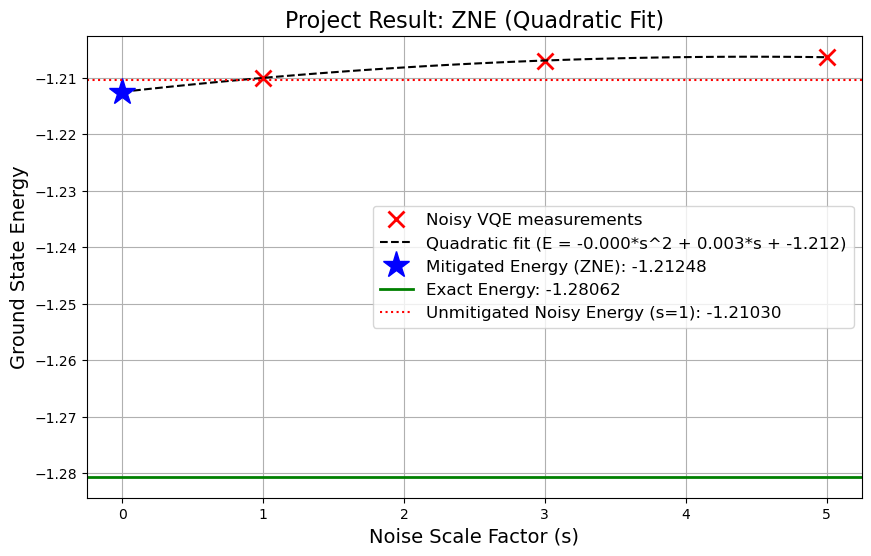

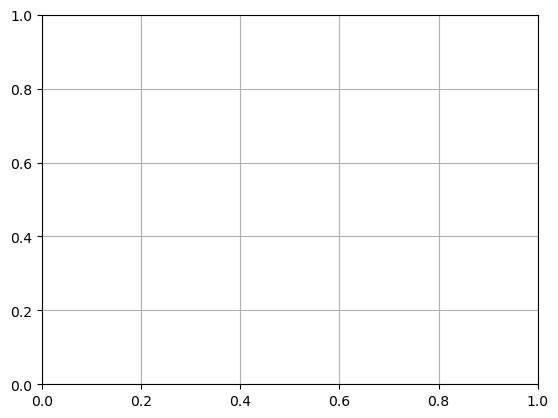

In [20]:
# --- Step 6B: Fit Data (Quadratic) and Plot Extrapolation ---

# 1. Define the QUADRATIC function we are fitting to:
# E(s) = a*s^2 + b*s + E_0
def quadratic_fit(s, a, b, e0):
    return a * (s**2) + b * s + e0

print("\n--- ZNE Analysis (Quadratic Fit) ---")
print(f"Noise scales: {noise_scale_factors}")
print(f"Energies measured: {[round(e, 5) for e in vqe_energies_at_scales]}")

# 2. Use curve_fit to find the best 'a', 'b', and 'e0'
try:
    params, _ = curve_fit(quadratic_fit, noise_scale_factors, vqe_energies_at_scales)
    a, b, e0_extrapolated = params
    
    print("\n--- ZNE Fit Results (Quadratic) ---")
    print(f"Fitted a (s^2 term): {a:.5f}")
    print(f"Fitted b (s term):   {b:.5f}")
    print(f"Fitted intercept (E_0): {e0_extrapolated:.5f}  <-- This is our Mitigated Result!")

    # 3. Plot the ZNE extrapolation
    plt.figure(figsize=(10, 6))
    plt.plot(noise_scale_factors, vqe_energies_at_scales, 'rx', markersize=12, mew=2, label='Noisy VQE measurements')

    # Plot the fitted quadratic curve
    s_fit = np.linspace(0, max(noise_scale_factors), 100)
    e_fit = quadratic_fit(s_fit, a, b, e0_extrapolated)
    plt.plot(s_fit, e_fit, 'k--', label=f'Quadratic fit (E = {a:.3f}*s^2 + {b:.3f}*s + {e0_extrapolated:.3f})')

    # Plot the extrapolated E_0
    plt.plot(0, e0_extrapolated, 'b*', markersize=20, label=f'Mitigated Energy (ZNE): {e0_extrapolated:.5f}')

    # Plot the ideal and noisy reference lines
    plt.axhline(exact_eigenvalue, color='g', linestyle='-', linewidth=2, label=f'Exact Energy: {exact_eigenvalue:.5f}')
    plt.axhline(noisy_vqe_result.eigenvalue, color='r', linestyle=':', label=f'Unmitigated Noisy Energy (s=1): {noisy_vqe_result.eigenvalue:.5f}')

    plt.title('Project Result: ZNE (Quadratic Fit)', fontsize=16)
    plt.xlabel('Noise Scale Factor (s)', fontsize=14)
    plt.ylabel('Ground State Energy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig('/Users/imjinhyeok/Documents/GitHub/Quantum-NoIse-and-Algorithms/01_vqe_ising_noise/zne_results/zne_avg10_quadratic.png')
    plt.show()

except RuntimeError:
    print("\n--- Error ---")
    print("Could not find a quadratic fit. The data points might be too collinear or noisy.")
    print("Try re-running Step 6A or Step 6C (averaging) for more stable data.")
plt.grid(True)
plt.show()


--- ZNE Fit Results (Averaged + Quadratic) ---
--- Single Run (Quadratic) ---
Fitted intercept (E_0): -1.21248
--- Averaged Run (Quadratic) ---
Fitted a (s^2 term): -0.00463
Fitted b (s term):   0.02764
Fitted intercept (E_0_avg): -1.23102  <-- This is our Robust Mitigated Result!


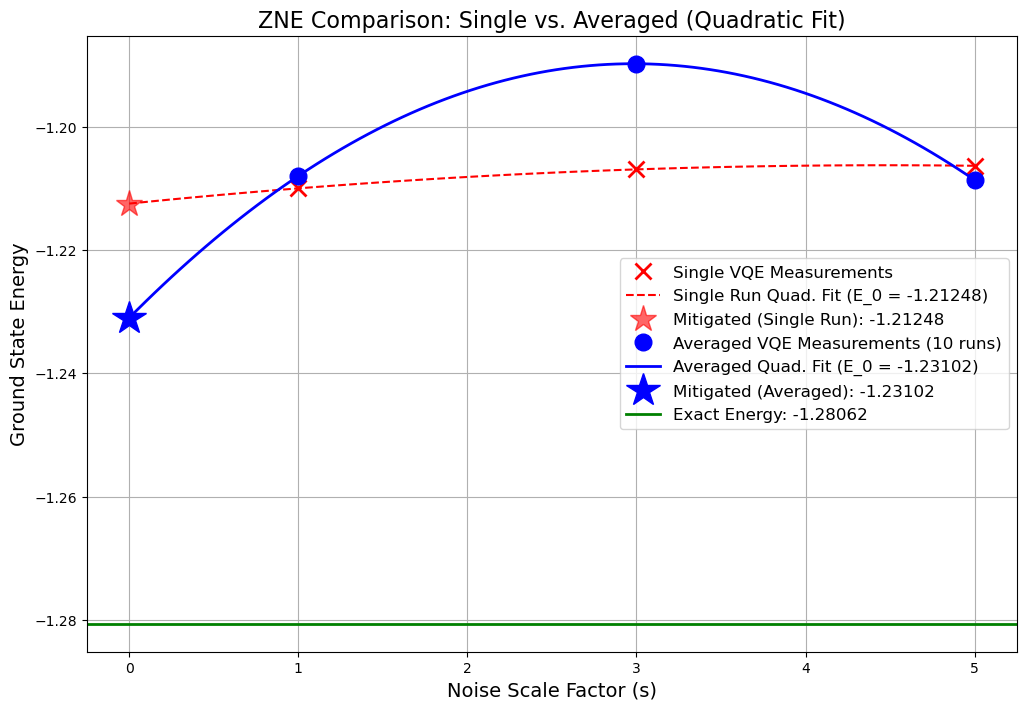

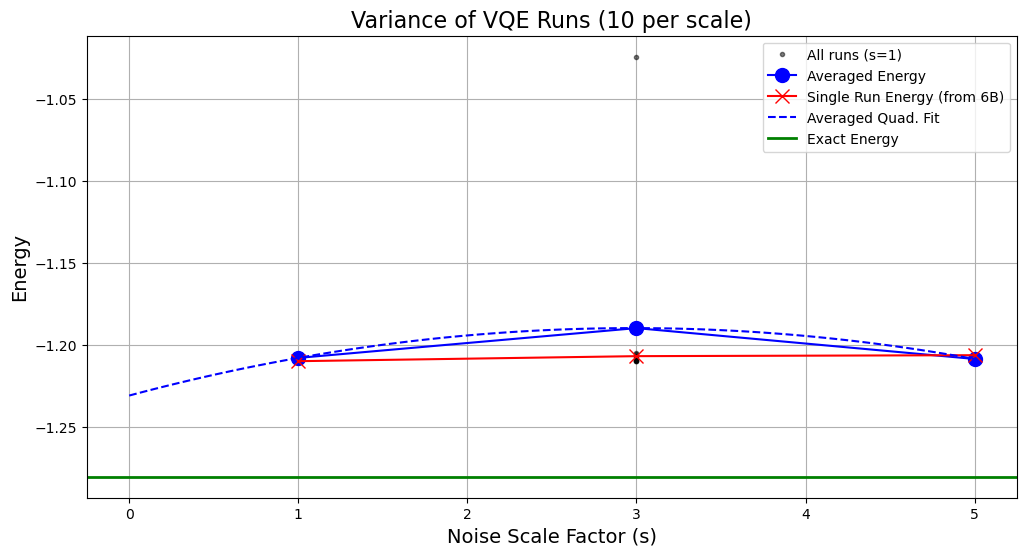

In [22]:
# --- Step 6C의 4번, 5번 부분을 이걸로 교체 ---

# 4. *평균* 데이터로 2차 함수 ZNE 피팅
print("\n--- ZNE Fit Results (Averaged + Quadratic) ---")

# E(s) = a*s^2 + b*s + E_0
def quadratic_fit(s, a, b, e0):
    return a * (s**2) + b * s + e0

# (A) 단일 실행(6B) 데이터로 2차 피팅
popt_single, _ = curve_fit(quadratic_fit, noise_scale_factors, vqe_energies_at_scales)
a_single, b_single, e0_extrapolated_single = popt_single

# (B) 평균(6C) 데이터로 2차 피팅
popt_avg, _ = curve_fit(quadratic_fit, noise_scale_factors, vqe_energies_avg)
a_avg, b_avg, e0_extrapolated_avg = popt_avg

print(f"--- Single Run (Quadratic) ---")
print(f"Fitted intercept (E_0): {e0_extrapolated_single:.5f}")
print(f"--- Averaged Run (Quadratic) ---")
print(f"Fitted a (s^2 term): {a_avg:.5f}")
print(f"Fitted b (s term):   {b_avg:.5f}")
print(f"Fitted intercept (E_0_avg): {e0_extrapolated_avg:.5f}  <-- This is our Robust Mitigated Result!")


# --- 5. 비교 플롯 그리기 (단일 실행 vs 평균 실행) ---
plt.figure(figsize=(12, 8))
plt.title('ZNE Comparison: Single vs. Averaged (Quadratic Fit)', fontsize=16)

# (1) 단일 실행 ZNE (Quadratic) - 빨간색
plt.plot(noise_scale_factors, vqe_energies_at_scales, 'rx', markersize=12, mew=2, label='Single VQE Measurements')
s_fit_single = np.linspace(0, max(noise_scale_factors), 100)
e_fit_single = quadratic_fit(s_fit_single, a_single, b_single, e0_extrapolated_single)
plt.plot(s_fit_single, e_fit_single, 'r--', label=f'Single Run Quad. Fit (E_0 = {e0_extrapolated_single:.5f})')
plt.plot(0, e0_extrapolated_single, 'r*', markersize=20, alpha=0.6, label=f'Mitigated (Single Run): {e0_extrapolated_single:.5f}')

# (2) 평균 실행 ZNE (Quadratic) - 파란색
plt.plot(noise_scale_factors, vqe_energies_avg, 'bo', markersize=12, label=f'Averaged VQE Measurements ({num_runs} runs)')
s_fit_avg = np.linspace(0, max(noise_scale_factors), 100)
e_fit_avg = quadratic_fit(s_fit_avg, a_avg, b_avg, e0_extrapolated_avg)
plt.plot(s_fit_avg, e_fit_avg, 'b-', linewidth=2, label=f'Averaged Quad. Fit (E_0 = {e0_extrapolated_avg:.5f})')
plt.plot(0, e0_extrapolated_avg, 'b*', markersize=25, label=f'Mitigated (Averaged): {e0_extrapolated_avg:.5f}')

# (3) 참조선 (정답)
plt.axhline(exact_eigenvalue, color='g', linestyle='-', linewidth=2, label=f'Exact Energy: {exact_eigenvalue:.5f}')

plt.xlabel('Noise Scale Factor (s)', fontsize=14)
plt.ylabel('Ground State Energy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('/Users/imjinhyeok/Documents/GitHub/Quantum-NoIse-and-Algorithms/01_vqe_ising_noise/zne_results/zne_quad_single_vs_avg10.png')
plt.show()


# --- (보너스 플롯) VQE 실행의 분산(Variance) 시각화 ---
# (이 플롯 코드는 수정할 필요 없이 그대로 사용 가능합니다)
plt.figure(figsize=(12, 6))
for scale in noise_scale_factors:
    plt.plot([scale]*num_runs, all_run_data[scale], 'k.', alpha=0.5, label=f'All runs (s={scale})' if scale==1 else None)
    
plt.plot(noise_scale_factors, vqe_energies_avg, 'bo-', markersize=10, label='Averaged Energy')
plt.plot(noise_scale_factors, vqe_energies_at_scales, 'rx-', markersize=10, label='Single Run Energy (from 6B)')
plt.plot(s_fit_avg, e_fit_avg, 'b--', label='Averaged Quad. Fit') # <-- 레이블만 살짝 수정
plt.axhline(exact_eigenvalue, color='g', linestyle='-', linewidth=2, label='Exact Energy')

plt.title(f'Variance of VQE Runs ({num_runs} per scale)', fontsize=16)
plt.xlabel('Noise Scale Factor (s)', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('/Users/imjinhyeok/Documents/GitHub/Quantum-NoIse-and-Algorithms/01_vqe_ising_noise/zne_results/zne_quad_single_vs_avg10.png')
plt.show()